In [ ]:
import os
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd "/gdrive/Shared drives/deep learning"

Mounted at /gdrive
/gdrive/Shared drives/deep learning


In [ ]:
training_mediums = ['bell','guitar2','guitar3','guitar5','guitar6','beep','drums_2','glass','guitar1','horn','clap','guitar4']
validation_mediums = ['steel']
testing_mediums = ['steel']

# Path to the data directory
data_dir = "data/images_larger"
label_path = "data/labels.json"
epochs = 50

checkpoint_path = "checkpoints/ctc_large_images"
model_name = "{}_epochs_{}".format(epochs, '_'.join(testing_mediums))
model_save_path = os.path.join(checkpoint_path, model_name)
model_load_path = os.path.join(checkpoint_path, model_name)
history_path = "history/ctc_large_images"
history_name = "{}_history".format('_'.join(training_mediums))
history_save_path = os.path.join(history_path, history_name)
print(history_save_path)
print(model_name)
#model.save_weights(model_save_path)
#model.load_weights(model_load_path)

MAX_TEXT_SIZE=50
labels_train = []
labels_val = []
labels_test = []
# Get list of all the images
images = glob.glob(os.path.join(data_dir, "*.ogg.png"))
print([image.split('.')[0].split('_')[-1] for image in images])
images_train = [f for f in glob.glob(os.path.join(data_dir, "*.ogg.png")) if f.split('.')[0].split('_')[-1] in training_mediums]
text_labels_train = [img.split(os.path.sep)[-1].split(".ogg.png")[0] for img in images_train]

with open(label_path) as f:
  data_dict = json.load(f)
  for l in text_labels_train:
    labels_train.append(data_dict[l].ljust(MAX_TEXT_SIZE).lower())

images_val = [f for f in glob.glob(os.path.join(data_dir, "*.ogg.png")) if f.split('.')[0].split('_')[-1] in validation_mediums]
text_labels_val = [img.split(os.path.sep)[-1].split(".ogg.png")[0] for img in images_val]

with open(label_path) as f:
  data_dict = json.load(f)
  for l in text_labels_val:
    labels_val.append(data_dict[l].ljust(MAX_TEXT_SIZE).lower())

images_test = [f for f in glob.glob(os.path.join(data_dir, "*.ogg.png")) if f.split('.')[0].split('_')[-1] in testing_mediums]
text_labels_test = [img.split(os.path.sep)[-1].split(".ogg.png")[0] for img in images_test]

with open(label_path) as f:
  data_dict = json.load(f)
  for l in text_labels_test:
    labels_test.append(data_dict[l].ljust(MAX_TEXT_SIZE).lower())

characters = list('abcdefghijklmnopqrstuvwxyz0123456789,.?;:-_()=+@$!&/\'\" ')

print("Number of training images found: ", len(images_train))
print("Number of training labels found: ", len(labels_train))
print("Number of testing images found: ", len(images_test))
print("Number of testing labels found: ", len(labels_test))
print("Number of validation images found: ", len(images_val))
print("Number of validation labels found: ", len(labels_val))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

batch_size = 32

# Desired image dimensions
img_width = 650
img_height = 550
# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels_train])

history/ctc_large_images/bell_guitar2_guitar3_guitar5_guitar6_beep_drums_2_glass_guitar1_horn_clap_guitar4_history
50_epochs_steel
['guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'guitar1', 'horn', 'horn', 'horn', 'horn', 'horn', 'horn', 'horn', 'horn', 'horn', 'horn', 'horn', 'horn', 'horn', 'horn', 'horn', 'horn', 'horn', 'horn', 'horn', 'horn', 'horn', 'horn', 'horn', 'horn', 'horn

In [ ]:
print(max_length)

In [ ]:
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


# def split_data(images, labels, train_size=0.9, shuffle=True):
#     # 1. Get the total size of the dataset
#     size = len(images)

#     # 2. Make an indices array and shuffle it, if required
#     indices = np.arange(size)
#     if shuffle:
#         np.random.shuffle(indices)

#     # 3. Get the size of training samples
#     train_samples = int(size * train_size)

#     # 4. Split data into training and test sets
#     x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
#     x_test, y_test = images[indices[train_samples:]], labels[indices[train_samples:]]
#     return x_train, x_test, y_train, y_test

# Splitting data into training and validation sets
# x_train, x_val, y_train, y_val = split_data(np.array(images_train), np.array(labels_train))

x_train, y_train = np.array(images_train), np.array(labels_train)
x_val, y_val = np.array(images_val), np.array(labels_val)
x_test, y_test = np.array(images_test), np.array(labels_test)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

(10349,) (10349,)
(940,) (940,)
(940,) (940,)


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

shuffle_buffer_size = len(train_dataset)
train_dataset = train_dataset.shuffle(shuffle_buffer_size)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = (
    val_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = (
    test_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

In [ ]:
# for batch in train_dataset.take(1):
#   images = batch["image"]
#   labels = batch["label"]
#   print(labels)
#   break
# print(text_labels[1])

In [ ]:
# n = 3
# # print(train_dataset.take(1))
# _, ax = plt.subplots(n, n, figsize=(n*6, n*2))
# for batch in train_dataset.take(1):
#     images = batch["image"][:10]
#     labels = batch["label"][:10]
#     for i in range(n**2):
#         img = (images[i] * 255).numpy().astype("uint8")
#         label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
#         ax[i // n, i % n].imshow(img[:, :, 0].T, cmap="gray")
#         ax[i // n, i % n].set_title(label)
#         ax[i // n, i % n].axis("off")
# plt.show()

In [ ]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 32)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(32, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    #x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(len(characters) + 1, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt,metrics = [tf.keras.metrics.Accuracy()])
    return model


In [ ]:
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 650, 550, 1) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 650, 550, 64) 640         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 325, 275, 64) 0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 325, 275, 32) 18464       pool1[0][0]                      
_______________________________________________________________________________________

In [ ]:
# epochs = epochs
# early_stopping_patience = 5
# # Add early stopping
# early_stopping = keras.callbacks.EarlyStopping(
#     monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
# )

# # Train the model
# history = model.fit(
#     train_dataset,
#     validation_split=0.2,
#     epochs=epochs,
#     callbacks=[early_stopping])

In [ ]:
epochs = epochs
early_stopping_patience = 5
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs=epochs)
    # callbacks=[early_stopping])

Epoch 1/50
324/324 [==============================] - 140s 432ms/step - loss: 156.2258 - accuracy: 0.0000e+00 - val_loss: 151.3300 - val_accuracy: 0.0000e+00
Epoch 2/50
324/324 [==============================] - 80s 247ms/step - loss: 134.5765 - accuracy: 0.0000e+00 - val_loss: 77.6794 - val_accuracy: 0.0000e+00
Epoch 3/50
324/324 [==============================] - 80s 247ms/step - loss: 63.5087 - accuracy: 0.0000e+00 - val_loss: 20.1482 - val_accuracy: 0.0000e+00
Epoch 4/50
324/324 [==============================] - 80s 247ms/step - loss: 38.3430 - accuracy: 0.0000e+00 - val_loss: 12.7794 - val_accuracy: 0.0000e+00
Epoch 5/50
324/324 [==============================] - 80s 247ms/step - loss: 29.1765 - accuracy: 0.0000e+00 - val_loss: 9.3204 - val_accuracy: 0.0000e+00
Epoch 6/50
324/324 [==============================] - 80s 247ms/step - loss: 24.6579 - accuracy: 0.0000e+00 - val_loss: 8.7186 - val_accuracy: 0.0000e+00
Epoch 7/50
324/324 [==============================] - 80s 247ms/step

In [ ]:
with open(history_save_path, 'wb') as file:
  pickle.dump(history.history, file)

In [ ]:
# with open(history_save_path, 'rb') as file:
#   h = pickle.load(file)
# print(h) 

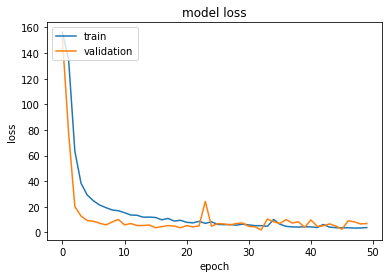

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(test_dataset) 

60/60 [==============================] - 15s 249ms/step - loss: 30.9704 - accuracy: 0.0000e+00


[30.97042465209961, 0.0]

In [ ]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
#prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


def count_num_errors(pred_texts, orig_texts):
  err_w = 0
  err_c = 0
  total_words = 0
  total_chars = 0
  for i in range(len(pred_texts)):
    pred_text = pred_texts[i]
    orig_text = orig_texts[i]

    pred_tokens = pred_text.split()
    orig_tokens = orig_text.split()

    pred_w_len = len(pred_tokens)
    orig_w_len = len(orig_tokens)
    total_words += max(pred_w_len, orig_w_len)
    # err_w = 0
    for w in range(min(pred_w_len, orig_w_len)):
      if pred_tokens[w] != orig_tokens[w]:
        err_w += 1
    
    pred_c_len = len(pred_text)
    orig_c_len = len(orig_text)
    total_chars += max(pred_c_len, orig_c_len)

    for c in range(min(pred_c_len, orig_c_len)):
      if pred_text[c] != orig_text[c]:
        err_c += 1
  return err_w, total_words, err_c, total_chars


# For random sampling from each batch
import random
samples_per_batch = 1
sample_text = ""
err_w, total_words, err_c, total_chars = 0, 0, 0, 0

# Iterate over the test dataset batches
sample_ind = 1
for batch in test_dataset.as_numpy_iterator():
  batch_images = batch["image"]
  batch_labels = batch["label"]
  
  preds = prediction_model.predict(batch_images)
  pred_texts = decode_batch_predictions(preds)

  orig_texts = []
  for label in batch_labels:
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    orig_texts.append(label)

  m1, m2, m3, m4 = count_num_errors(pred_texts, orig_texts)
  err_w += m1
  total_words += m2
  err_c += m3
  total_chars += m4

  if random.random() < 0.4:
    batch_size = len(pred_texts)
    sample_indices = random.sample(range(batch_size), samples_per_batch)
    for i in sample_indices:
      sample_text += "Sample #{}\n".format(sample_ind)
      sample_text += "Ground truth:  \t{}\n".format(orig_texts[i])
      sample_text += "Reconstruction:\t{}\n\n".format(pred_texts[i])
      sample_ind += 1

word_error = err_w / total_words if total_words != 0 else 0
char_error = err_c / total_chars if total_chars != 0 else 0
accuracy_text = "Accurate words: \t{}/{}\n".format(total_words - err_w, total_words)
accuracy_text += "Word level accuracy: \t{}\n\n".format(1 - word_error)
accuracy_text += "Accurate chars: \t{}/{}\n".format(total_chars - err_c, total_chars)
accuracy_text += "Char level accuracy: \t{}\n".format(1 - char_error)

print(accuracy_text)
print(sample_text)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Accurate words: 	6457/8285
Word level accuracy: 	0.7793602896801448

Accurate chars: 	43992/47496
Char level accuracy: 	0.9262253663466398

Sample #1
Ground truth:  	parallelisation of the critical daisy classifier c
Reconstruction:	parallelisatson of the clitical dassy classifsel c

Sample #2
Ground truth:  	greg and alice were members of melbourne punk band
Reconstruction:	greg and alice wele members of melbovrne punx band

Sample #3
Ground truth:  	minoan art is the art produced by the minoan civil
Reconstruction:	minoan alt is the art ploduced by the minoun civil

Sample #4
Ground truth:  	the concept of an enemy has been observed to be "b
Reconstruction:	the concept of an enemy has been observed to be "b

Sample #5
Ground truth:  	the six part series is written by blake ayshford. 
Reconstruction:	the six part herses ih written by blake ayshford.[UNK]

Sample #6
Ground truth:  	it is 

In [ ]:
model.save_weights(model_save_path)